## Pyro code for examples in MBML book by John Winn
#### Based on version 0.7 of the early access version (www.mbmlbook.com)
Implementation and testing of ideas from the book

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import operator

import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from pyro import param
from pyro.poutine import trace
from pyro import condition
from pyro.optim import Adam, ClippedAdam
from pyro.infer import SVI, Trace_ELBO, HMC, MCMC, NUTS
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoContinuous

from torch import tensor
from pprint import pprint


import pandas as pd
import matplotlib.pyplot as plt

from functools import reduce

from os.path import join, exists, basename


display('pyro version: {}'.format(pyro.__version__))

pyro.set_rng_seed(101)

/home/martin/mambaforge/envs/pyro/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'pyro version: 1.4.0'

# Some warmup exercises to understand distributions

#### Page 17, bullet 4

Define a Bernoulli distribution with a probability estimate of 0.3, then look at frequency of True/False in this disribution

In [2]:
murderer = dist.Bernoulli(0.3)

print('num True:', int(sum([pyro.sample('murderer', murderer) for s in range(100)])))

num True: 28


#### Page 23, bullet 3

Make the probability of being late conditioned on whether traffic is good or bad

In [3]:
late = {'bad':dist.Bernoulli(0.5), 'good':dist.Bernoulli(0.05)}

print('late in bad traffic:', int(sum([pyro.sample('bad', late['bad']) for s in range(100)])), 
      'late in good traffic:', int(sum([pyro.sample('good', late['good']) for s in range(100)])))

late in bad traffic: 55 late in good traffic: 5


#### Page 31, bullet 4

Print out 1000 joint samples of both variables

In [4]:
late = {'bad':dist.Bernoulli(0.5), 'good':dist.Bernoulli(0.05)}

print('bad traffic and late', int(sum([pyro.sample('badlate', late['bad']) for s in range(1000)])))
print('bad traffic and on time', 1000-int(sum([pyro.sample('badontime', late['bad']) for s in range(1000)])))
print('good traffic and late', int(sum([pyro.sample('goodlate', late['good']) for s in range(1000)])))
print('good traffic and on time', 1000-int(sum([pyro.sample('goodontime', late['good']) for s in range(1000)])))

bad traffic and late 531
bad traffic and on time 505
good traffic and late 53
good traffic and on time 945


# Chapter 1
## A murder mystery 
#### Pages 13-46

<img src="images/house.png" width="250"/>

**Problem statement:** Mr Black lies dead on the floor. The two murder suspects are Miss Auburn and Major Grey. There are two possible murder weapons, a revolver and a knife. Finally, a grey hair is found and this could either have been dropped by Grey if he is the killer or it could have placed by Auburn if she is the killer. The goal of this problem is to incorporate evidence and update beliefs regarding who the killer might be.

\
**Prior:** Initial suspicion is toward Miss Auburn with a probability of 70%, giving: 

\begin{align} 
P(murderer=Auburn)=0.7 \\
P(murderer=Grey)=0.3
\end{align}

\
**Weapon:** There are two possible murder weapons, a revolver and a dagger. The probabilities of each being used is conditional on the killer, giving:

\begin{align} 
P(weapon=revolver|murderer=Auburn)=0.2 \\
P(weapon=knife|murderer=Auburn)=0.8 \\
P(weapon=revolver|murderer=Grey)=0.9 \\
P(weapon=knife|murderer=Grey)=0.1
\end{align}


\
**Hair:** A hair is found at the crime scene. Indicating Major Grey. However it could also have been planted by Auburn. We think there is a 50% chance that Grey would drop the hair if he is the killer, but only a 5% chance that Auburn would think to plant a grey hair in the crime scene.
\begin{align} 
P(hair=true|murderer=Auburn)=0.05 \\
P(hair=false|murderer=Auburn)=0.95 \\
P(hair=true|murderer=Grey)=0.5 \\
P(hair=false|murderer=Grey)=0.5
\end{align}


**Factor graph:**
<img src="images/chapter_1.png" width="250"/>

In [5]:
# build murder mystery model

murderer_dict = {0:'Grey', 1:'Auburn'}
weapon_dict = {0:'Knife', 1:'Revolver'}
hair_dict = {0:'Not found', 1:'Found'}

def murder_case():
    '''
    The murder case model. Weapon and hair
    conditional on the murderer.
    '''
    
    # probability of murderer (0 is Grey and 1 is Auburn)
    murderer = pyro.sample('murderer', dist.Bernoulli(0.7)).item()

    # probability of weapon conditional on murderer (0 is knife and 1 is revolver)
    weapon = pyro.sample('weapon', {'Grey':dist.Bernoulli(0.9), 'Auburn':dist.Bernoulli(0.2)}[murderer_dict[murderer]])

    # probability of hair found conditional on murderer (0 is not found and 1 is found)
    hair = pyro.sample('hair', {'Grey':dist.Bernoulli(0.5), 'Auburn':dist.Bernoulli(0.05)}[murderer_dict[murderer]])


### We can explore the model using repeated sampling

**We first look at all the variables in the model.** $P(murderer)$, $P(weapon)$, $P(hair)$

These correspond to our initial beliefs.

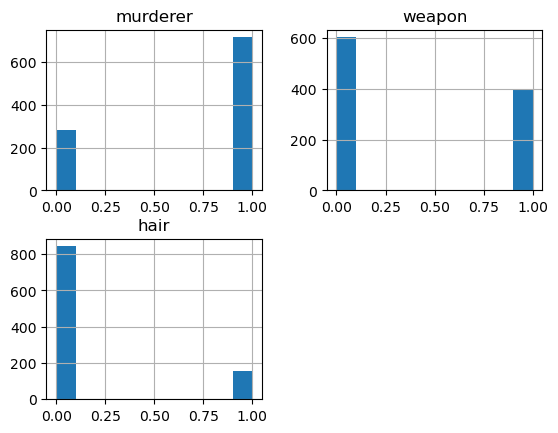

In [6]:
    
# make plots of the various probabilities involved
num_samples = 1000
traces = []

for _ in range(num_samples):
    tr = trace(murder_case).get_trace()
    values = {
        name: props['value'].item()
        for (name, props) in tr.nodes.items()
        if props['type'] == 'sample'
    }
    traces.append(values)

_ = pd.DataFrame(traces).hist()


**We can condition the model** and ask what the joint probability for an outcome is. For example, how likely is the outcome that Auburn is the killer, the revolver was used and the hair is found $P(murderer=Auburn, weapon=Revolver, hair=true)$? Note that this is *not* the likelyhood that Auburn is the killer given the evidence, it is the likelyhood of the overall outcome at the outset.

In [7]:
# Condition the model
cond_model = condition(murder_case, {
    "murderer": tensor(1.),
    "weapon": tensor(1.),
    "hair": tensor(1.)
})


# setup trace
tr = trace(cond_model).get_trace()

print('Joint probability for this particular outcome: {:.2}'.format(tr.log_prob_sum().exp().item()))

Joint probability for this particular outcome: 0.007


**To find the relative probability** of the two potential murderers given the evidence of the revolver and hair we need to compute both. $P(murderer=Auburn|weapon=Revolver, hair=true)$ and $P(murderer=Grey|weapon=Revolver, hair=true)$

In [8]:
# Condition the model for Auburn
cond_model = condition(murder_case, {
    "murderer": tensor(1.),
    "weapon": tensor(1.),
    "hair": tensor(1.)
})

tr = trace(cond_model).get_trace()
auburn = tr.log_prob_sum().exp()


# Condition the model for Grey
cond_model = condition(murder_case, {
    "murderer": tensor(0.),
    "weapon": tensor(1.),
    "hair": tensor(1.)
})

# Compute the probabilities
tr = trace(cond_model).get_trace()
grey = tr.log_prob_sum().exp()


# calculate the relative probabilities
auburn_prob = auburn/(auburn+grey)
grey_prob = grey/(auburn+grey)

print('After seeing evidence the probability for Auburn being the murderer is {:.2} and Grey is {:.2}.'.format(auburn_prob, grey_prob))

After seeing evidence the probability for Auburn being the murderer is 0.049 and Grey is 0.95.


### We can also use variational inference to look at latent variables
This will become useful for larger models.

**To find the probability** of Auborn being the murderer, after seeing the revolver evidence. $P(murderer=Auburn|weapon=Revolver)$

Probability for Auburn being the murderer is now 0.33


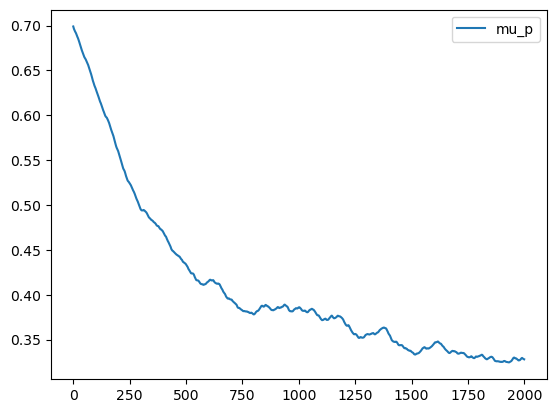

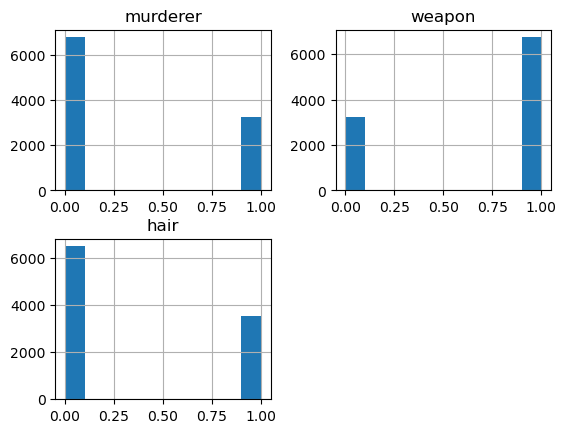

In [9]:

def case_guide():
    '''
    Guide function used to find optimal values of latent variables.
    '''
    # Constraints ensure facts always remain true during optimization,
    # e.g. that the parameter of a Bernoulli is always between 0 and 1
    valid_prob = dist.constraints.interval(0., 1.)
    mu_p = param('mu_p', tensor(0.7), constraint=valid_prob)
    murderer = pyro.sample('murderer', dist.Bernoulli(mu_p))

    # probability of weapon conditional on murderer (0 is knife and 1 is revolver)
    weapon = pyro.sample('weapon', {'Grey':dist.Bernoulli(0.9), 'Auburn':dist.Bernoulli(0.2)}[murderer_dict[murderer.item()]])
    
    # probability of hair found conditional on murderer (0 is not found and 1 is found)
    hair = pyro.sample('hair', {'Grey':dist.Bernoulli(0.5), 'Auburn':dist.Bernoulli(0.05)}[murderer_dict[murderer.item()]])

    

# remove previous
pyro.clear_param_store()

# Condition the model on having seen the revolver
cond_model = condition(murder_case, {
    "weapon": tensor(1.)
})
# Condition the guide on having seen the revolver
cond_case_guide = condition(case_guide, {
    "weapon": tensor(1.)
})


adam = Adam({"lr": 0.005, "betas": (0.90, 0.999)})
svi = SVI(cond_model, case_guide, adam, loss=Trace_ELBO())

param_vals = []
for _ in range(2000):
    svi.step()
    param_vals.append({k: param(k).item() for k in ["mu_p"]})

    
# plot the parameter
pd.DataFrame(param_vals).plot(subplots=True)
  
      
# make plots of the various probabilities involved
traces = []
for _ in range(10000):
    tr = trace(case_guide).get_trace()
    values = {
        name: props['value'].item()
        for (name, props) in tr.nodes.items()
        if props['type'] == 'sample'
    }
    traces.append(values)

_ = pd.DataFrame(traces).hist()


# what is the murderer probability now?
tr = trace(case_guide).get_trace()
print('Probability for Auburn being the murderer is now {:.2}'.format(tr.nodes['mu_p']['value'].item()))

**To find the probability** of Auborn being the murderer, after seeing the revolver *and* hair evidence $P(murderer=Auburn|weapon=Revolver, hair=true)$. This will be the same value (or at least very similar, depending on how many iterations are used) as the 0.049 from a few cells above where we computed relative probability.

Probability for Auburn being the murderer is now 0.049
CPU times: user 10.2 s, sys: 16 ms, total: 10.2 s
Wall time: 10.2 s


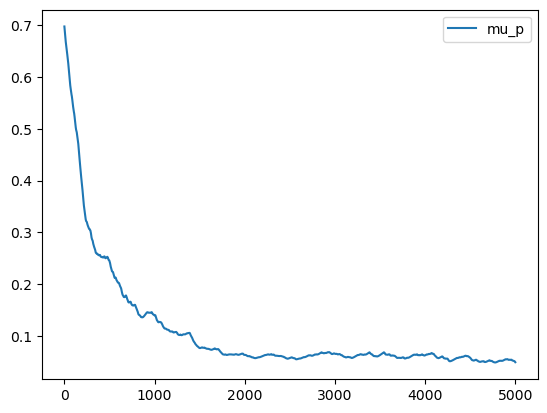

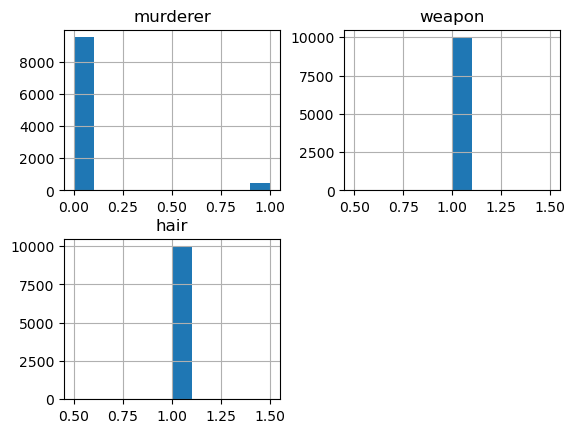

In [10]:
%%time

# remove previous
pyro.clear_param_store()

# Condition the model on having seen the revolver and hair
cond_model = condition(murder_case, {
    "weapon": tensor(1.),
    "hair": tensor(1.)
})
    

# Condition the guide on having seen the revolver and hair
cond_case_guide = condition(case_guide, {
    "weapon": tensor(1.),
    "hair": tensor(1.)
})

adam = Adam({"lr": 0.01, "betas": (0.90, 0.999)})
svi = SVI(cond_model, cond_case_guide, adam, loss=Trace_ELBO())

param_vals = []
for _ in range(5000):
    svi.step()
    param_vals.append({k: param(k).item() for k in ["mu_p"]})

    
# plot the loss
pd.DataFrame(param_vals).plot(subplots=True)
      
      
# make plots of the various probabilities involved
traces = []
for _ in range(10000):
    tr = trace(cond_case_guide).get_trace()
    values = {
        name: props['value'].item()
        for (name, props) in tr.nodes.items()
        if props['type'] == 'sample'
    }
    traces.append(values)

_ = pd.DataFrame(traces).hist()


# what is the murderer probability now?
tr = trace(cond_case_guide).get_trace()
print('Probability for Auburn being the murderer is now {:.2}'.format(tr.nodes['mu_p']['value'].item()))